### Table of Contents

* [1.0 Purpose](#1.0)
    * [1.1 Imports](#1.1)
    * [1.2 Load the data](#1.2)
    * [1.3 Inspect the data](#1.3)
* [2.1 Proportion of classes](#2.1)
    * [2.2 Dummy encoding](#2.2)
* [3.1 Split dataframe into features and target](#3.1)
    * [3.2 Preliminary modeling](#3.2)
    * [3.3 Preliminary model confusion matrix and classification report](#3.3)
* [4.0 Logistic regression model](#4.0)    
    * [4.1 Tuning hyperparameters using a pipeline and GridSearchCV](#4.1)
    * [4.2 Build a function to run GridSearchCV](#4.2)
    * [4.3 Build a function to exclude highly correlated features](#4.3)
    * [4.4 Recall results with "hold out" features to loop through](#4.4)
    * [4.5 Individual model Recall results with excluded "hold out" features](#4.5)

##### 1.0 Purpose<a id='1.0'></a>

In the previous notebook, we completed exploratory data analysis. The data was visualized in terms of correlations, both between features and targets, and between features and other features.

Now, in this notebook, we are in the preprocessing and training phase of this Capstone 2 project. We will be putting together different models for the training/testing process, then checking for accuracy.


##### 1.1 Imports<a id='1.1'></a>

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from datetime import datetime
#
# plotting and visualization
#
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
#
import seaborn as sns
#
# modeling
#
from sklearn.preprocessing import OneHotEncoder as OHE
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

##### 1.2 Load data<a id='1.2'></a>

In [2]:
path = r'C:\Users\Joseph Shire\Documents\Springboard Python Data Science\Python Scripts\springboard\Capstone2\Fetal health idea'
main_file = r'\ctg_final.csv'
df = pd.read_csv(path+main_file)
fc = r'\ctg_corr.csv'
fcorr = pd.read_csv(path+fc)
tc = r'\ctg_corr_NSP.csv'
tcorr = pd.read_csv(path+tc)

print('The main data have ', df.shape[0], ' rows and ', df.shape[1], ' columns\n')
print('column names: \n')
print('\n'.join(list(df.columns)))

The main data have  2126  rows and  22  columns

column names: 

LB
AC
FM
UC
ASTV
MSTV
ALTV
MLTV
DL
DS
DP
Width
Min
Max
Nmax
Nzeros
Mode
Mean
Median
Variance
Tendency
NSP


Look at the correlation dataframes

In [3]:
tcorr.head(10)

,var_1,var_2,correlation,abs_corr,corr_level
0,DP,NSP_3.0,0.580253,0.580253,MID
1,ASTV,NSP_1.0,-0.493391,0.493391,LOW
2,ALTV,NSP_1.0,-0.489400,0.489400,LOW
3,NSP_3.0,Mode,-0.419051,0.419051,LOW
4,ALTV,NSP_2.0,0.418659,0.418659,LOW
5,NSP_3.0,Mean,-0.416886,0.416886,LOW
6,Median,NSP_3.0,-0.384857,0.384857,LOW
7,AC,NSP_1.0,0.369470,0.369470,LOW
8,NSP_2.0,ASTV,0.348213,0.348213,LOW
9,LB,NSP_2.0,0.341922,0.341922,LOW


In [4]:
fcorr.head(10)

,var_1,var_2,correlation,abs_corr,corr_level
0,Median,Mean,0.948251,0.948251,HIGH
1,Mode,Median,0.933399,0.933399,HIGH
2,Min,Width,-0.898519,0.898519,HIGH
3,Mode,Mean,0.893412,0.893412,HIGH
4,LB,Median,0.789246,0.789246,HIGH
5,Width,Nmax,0.747071,0.747071,HIGH
6,Mean,LB,0.723121,0.723121,HIGH
7,Mode,LB,0.708993,0.708993,HIGH
8,Max,Width,0.690769,0.690769,MID
9,Min,Nmax,-0.670287,0.670287,MID


##### 2.1 Proportion of classes<a id='2.1'></a>

When building classification models, it is essential to know right away the number of samples per class, proportionally to the total number of samples.

For our fetal health data, the diagnostic categories are: 1 = Normal = N, 2 = Suspect = S, 3 = Pathological = P.

In [5]:
class_counts_nsp = df['NSP'].value_counts()
print('Raw totals:\n')
print(class_counts_nsp)

Raw totals:

1.0    1655
2.0     295
3.0     176
Name: NSP, dtype: int64


In [6]:
class_p_nsp = pd.Series([(x / df.shape[0]) * 100.00 for x in class_counts_nsp], index=[1,2,3])
print('Percentages:\n')
print(class_p_nsp)

Percentages:

1    77.845720
2    13.875823
3     8.278457
dtype: float64


Visualize Proportionality

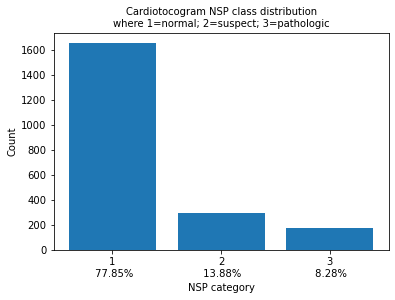

In [7]:
fig, ax = plt.subplots()
ax.bar(class_counts_nsp.index, class_counts_nsp)
ax.set_xticks([1,2,3])
ax.set_xticklabels(class_p_nsp.index.astype(str) + '\n' + ' ' +
                   class_p_nsp.round(2).astype(str) + '%')

ax.set_ylabel('Count')
ax.set_xlabel('NSP category')
ax.set_title('Cardiotocogram NSP class distribution\nwhere 1=normal; 2=suspect; 3=pathologic',
              fontsize = 10)
plt.show()

##### 2.2 Dummy encode only categorical feature<a id='2.2'></a>

The feature "Tendency" is a categorical variable, and will need dummies applied

In [8]:
df['Tendency'].value_counts()

 0.0    1115
 1.0     846
-1.0     165
Name: Tendency, dtype: int64

According to documentaiton, 'Tendency' is histogram tendency: -1=left assymetric; 0=symmetric; 1=right assymetric

In [9]:
dfd = pd.get_dummies(df, columns = ['Tendency'])
dfd

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,...,Nmax,Nzeros,Mode,Mean,Median,Variance,NSP,Tendency_-1.0,Tendency_0.0,Tendency_1.0
0,120.0,0.0,0.0,0.0,73.0,0.5,43.0,2.4,0.0,0.0,...,2.0,0.0,120.0,137.0,121.0,73.0,2.0,0,0,1
1,132.0,4.0,0.0,4.0,17.0,2.1,0.0,10.4,2.0,0.0,...,6.0,1.0,141.0,136.0,140.0,12.0,1.0,0,1,0
2,133.0,2.0,0.0,5.0,16.0,2.1,0.0,13.4,2.0,0.0,...,5.0,1.0,141.0,135.0,138.0,13.0,1.0,0,1,0
3,134.0,2.0,0.0,6.0,16.0,2.4,0.0,23.0,2.0,0.0,...,11.0,0.0,137.0,134.0,137.0,13.0,1.0,0,0,1
4,132.0,4.0,0.0,5.0,16.0,2.4,0.0,19.9,0.0,0.0,...,9.0,0.0,137.0,136.0,138.0,11.0,1.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.0,0.0,6.0,79.0,0.2,25.0,7.2,0.0,0.0,...,4.0,0.0,153.0,150.0,152.0,2.0,2.0,0,1,0
2122,140.0,1.0,0.0,9.0,78.0,0.4,22.0,7.1,0.0,0.0,...,6.0,0.0,152.0,148.0,151.0,3.0,2.0,0,0,1
2123,140.0,1.0,0.0,7.0,79.0,0.4,20.0,6.1,0.0,0.0,...,5.0,0.0,153.0,148.0,152.0,4.0,2.0,0,0,1
2124,140.0,1.0,0.0,9.0,78.0,0.4,27.0,7.0,0.0,0.0,...,6.0,0.0,152.0,147.0,151.0,4.0,2.0,0,0,1


##### 3.1 Split dataframe into features and target<a id='3.1'></a>

Setting our features as the X variable, and targets as the y variable for use in our modeling.

In [10]:
    dfd['NSP'] = df['NSP'].replace([1.0,2.0,3.0],['N','S','P'])

In [11]:
X = dfd.drop(columns = ['NSP'])

In [12]:
y = dfd['NSP']

In [13]:
print(X.head(),y.head())

      LB   AC   FM   UC  ASTV  MSTV  ALTV  MLTV   DL   DS  ...    Max  Nmax  \
0  120.0  0.0  0.0  0.0  73.0   0.5  43.0   2.4  0.0  0.0  ...  126.0   2.0   
1  132.0  4.0  0.0  4.0  17.0   2.1   0.0  10.4  2.0  0.0  ...  198.0   6.0   
2  133.0  2.0  0.0  5.0  16.0   2.1   0.0  13.4  2.0  0.0  ...  198.0   5.0   
3  134.0  2.0  0.0  6.0  16.0   2.4   0.0  23.0  2.0  0.0  ...  170.0  11.0   
4  132.0  4.0  0.0  5.0  16.0   2.4   0.0  19.9  0.0  0.0  ...  170.0   9.0   

   Nzeros   Mode   Mean  Median  Variance  Tendency_-1.0  Tendency_0.0  \
0     0.0  120.0  137.0   121.0      73.0              0             0   
1     1.0  141.0  136.0   140.0      12.0              0             1   
2     1.0  141.0  135.0   138.0      13.0              0             1   
3     0.0  137.0  134.0   137.0      13.0              0             0   
4     0.0  137.0  136.0   138.0      11.0              0             0   

   Tendency_1.0  
0             1  
1             0  
2             0  
3       

In [78]:
y.value_counts()

N    1655
S     295
P     176
Name: NSP, dtype: int64

##### 3.2 Preliminary modeling<a id='3.2'></a>

Start by training a single model on a single set of parameters, to see what non-tuned results might look like

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, stratify = y)

In [79]:
y_train.value_counts()

N    1323
S     236
P     141
Name: NSP, dtype: int64

In [80]:
y_test.value_counts()

N    332
S     59
P     35
Name: NSP, dtype: int64

Using Logistic Regression, with the solver 'liblinear', maximum iterations set to 500, and regularization (C) at 1000

In [48]:
lr = LogisticRegression(solver = 'liblinear', max_iter = 500, C = 1000)

We fit the training data to the model

In [49]:
lr.fit(X_train, y_train)

LogisticRegression(C=1000, max_iter=500, solver='liblinear')

Then assess recall scores for training and testing data

In [53]:
print('Recall on training data: ',recall_score(y_train,lr.predict(X_train), average='macro'))

Recall on training data:  0.799235683107371


In [54]:
print(f'Recall on test data: ',recall_score(y_test,lr.predict(X_test),average='macro'))

Recall on test data:  0.7187928469325243


##### 3.3 Preliminary model confusion matrix and classification report<a id='3.3'></a>

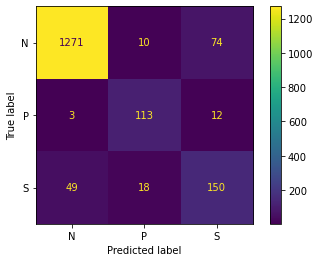

In [82]:
cm = confusion_matrix(lr.predict(X_train), y_train)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=lr.classes_)
ax.set_xticks([0, 2])
ax.set_yticks([0, 2])
display_cm.plot(ax = ax)


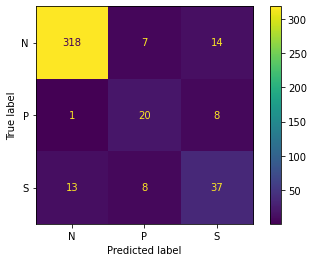

In [83]:
cm = confusion_matrix(lr.predict(X_test), y_test)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=lr.classes_)
ax.set_xticks([0, 2])
ax.set_yticks([0, 2])
display_cm.plot(ax = ax)

Right away, we can see that for class P (pathological), this model is not satisfactory. The true positives of the test set equal 20, but class P false negatives add up to 9, which is only a class P identification rate of 20/(20+9) = 68.97%

For a closer look at the performance, a classification report is created for both training and testing data

In [20]:
print("Classification Report for Training Data")
print(classification_report(y_train, lr.predict(X_train)))

Classification Report for Training Data
              precision    recall  f1-score   support

           N       0.94      0.96      0.95      1323
           P       0.89      0.79      0.83       141
           S       0.69      0.67      0.68       236

    accuracy                           0.91      1700
   macro avg       0.84      0.81      0.82      1700
weighted avg       0.90      0.91      0.91      1700



In [21]:
print("Classification Report for Test Data")
print(classification_report(y_test, lr.predict(X_test)))

Classification Report for Test Data
              precision    recall  f1-score   support

           N       0.93      0.95      0.94       332
           P       0.79      0.77      0.78        35
           S       0.66      0.59      0.62        59

    accuracy                           0.89       426
   macro avg       0.80      0.77      0.78       426
weighted avg       0.88      0.89      0.88       426



The model performs better than randomly guessing, but there is much room for improvement.

##### 4.0 Logistic regression model<a id='4.0'></a>

Now we can commense hyperparameter tuning to get a better feel for what parameters could give us the best predictive power

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

##### 4.1 Tuning hyperparameters using a pipeline and GridSearchCV<a id='4.1'></a>

Initially, we will look at a Logistic Regression model.
The first step is to crete a pipeline. Within this step, we scale our data, since there are vastly differing scales among our features.
Next, we include multiple levels of regularization (parameter 'C'), and multiple solvers.
Finally, we use GridSearchCV to check recall scores across all combinations of the parameter choices.

We will focus on recall for a scoring metric, due to class imbalance and the importance of reducing false negatives. The business interest lies in detecting pathological health conditions, so ensuring that Class P 'positives' are detected accurately is most important.

In [22]:
start_time = datetime.now()
#code to time

steps = [("scaler",StandardScaler()),("lr",LogisticRegression(max_iter = 8000))]
pipe = Pipeline(steps)

Cval = [0.0001, 0.001, 0.1, 1, 5, 10, 50, 100]
params = [{"lr__penalty":['none'], 'lr__solver': ['newton-cg','sag','lbfgs','saga']},{"lr__penalty":['l1'],"lr__solver":['liblinear','saga'],"lr__C":Cval},  {"lr__penalty":['l2'], 'lr__solver': ['liblinear','newton-cg','sag','lbfgs','saga'],"lr__C":Cval},{"lr__penalty":['elasticnet'],'lr__solver': ['saga'],'lr__l1_ratio':[0.2,0.5,0.8],"lr__C":Cval}]

grid = GridSearchCV(pipe, param_grid=params, scoring="recall_macro")
grid.fit(X_train, y_train)
results = pd.DataFrame(grid.cv_results_)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Duration: 0:16:12.375019


In [23]:
best_results = [grid.best_estimator_, grid.best_params_, grid.best_score_]
print(best_results)

[Pipeline(steps=[('scaler', StandardScaler()),
                ('lr',
                 LogisticRegression(C=1, max_iter=8000, penalty='l1',
                                    solver='saga'))]), {'lr__C': 1, 'lr__penalty': 'l1', 'lr__solver': 'saga'}, 0.8072552684831132]


In [24]:
grid.best_index_

11

In [25]:
filtered = results.iloc[:,[5,4,7,6,14]].sort_values(results.columns[14], ascending=False)
best_result = filtered.head(1)
best_result

,param_lr__solver,param_lr__penalty,param_lr__l1_ratio,param_lr__C,mean_test_score
11,saga,l1,NaN,1,0.807255


In [26]:
filtered.head(5)

,param_lr__solver,param_lr__penalty,param_lr__l1_ratio,param_lr__C,mean_test_score
11,saga,l1,NaN,1,0.807255
70,saga,elasticnet,0.5,1,0.805586
40,liblinear,l2,NaN,5,0.805062
42,sag,l2,NaN,5,0.804503
44,saga,l2,NaN,5,0.804503


In [27]:
attributes = filtered.columns
attributes[0]

'param_lr__solver'

In [28]:
solver = filtered[attributes[0]].iloc[0]
solver

'saga'

##### 4.2 Build a function to run GridSearchCV<a id='4.2'></a>

In [29]:
import math

In [30]:
def LR(X,y,Cval=[0.0001, 0.001, 0.1, 1, 5, 10, 50, 100],scoring="recall_macro",suppressCR=False):
    """
    X is X_train
    y is y_train
    Cval is a list of C regularizations to be tried, auto covers a wide range
    data is automatically scaled
    suppressCR is whether you want the final readout to display the classification reports,
        False means do display report, don't suppress it (default)
        True means don't display report, suppress it
    
    Logistic regression only, max_iter = 8000
    """
    #code to time how long this code runs for
    start_timeLR = datetime.now()
    
    # create a pipeline for scaled data in logistic regression
    steps = [("scaler",StandardScaler()),("lr",LogisticRegression(max_iter = 8000))]
    pipe = Pipeline(steps)
    
    # list parameters to be tried in our grid search.
    # all solvers at every penalty level included.
    # Cval is implemented here (defult is wide range of C values).
    params = [{"lr__penalty":['none'], 'lr__solver': ['newton-cg','sag','lbfgs','saga']},{"lr__penalty":['l1'],"lr__solver":['liblinear','saga'],"lr__C":Cval},  {"lr__penalty":['l2'], 'lr__solver': ['liblinear','newton-cg','sag','lbfgs','saga'],"lr__C":Cval},{"lr__penalty":['elasticnet'],'lr__solver': ['saga'],'lr__l1_ratio':[0.2,0.5,0.8],"lr__C":Cval}]
    
    # execute the grid search
    grid = GridSearchCV(pipe, param_grid=params, scoring=scoring)
    # fit the model
    grid.fit(X, y)
    # compile results in a dataframe
    results = pd.DataFrame(grid.cv_results_)
    # filter to only the desired columns and sort by performance
    filtered = results.iloc[:,[5,4,7,6,14]].sort_values(results.columns[14], ascending=False)
    filtered
    
    best_model = filtered.head(1)
    attributes = best_model.columns
    solver = best_model[attributes[0]].iloc[0]
    penalty = best_model[attributes[1]].iloc[0]
    l1_ratio = best_model[attributes[2]].iloc[0]
    Creg = best_model[attributes[3]].iloc[0]
    best_score = best_model[attributes[4]].iloc[0]

    
    if penalty == 'elasticnet':
        print('solver = ', solver,', penalty = ', penalty,', C = ', Creg,'l1 ratio = ', l1_ratio)

    else:
        print('solver = ', solver,', penalty = ', penalty,', C = ', Creg)
    print(scoring,' score = ', round(best_score,4),'\n')
    if suppressCR == False:
        print('_______________________________________')

        # run the best model and produce report
        if penalty == 'elasticnet':    
            best_model_lr = LogisticRegression(solver = solver, C = Creg, penalty=penalty, l1_ratio=l1_ratio, max_iter = 8000)
            best_model_lr.fit(X, y)
            print('Scoring = ',scoring)
            print("Classification Report for Training Data (using the best-performing model)")
            print(classification_report(y, best_model_lr.predict(X)))
            end_timeLR = datetime.now()
            print('Duration of this segment: {}'.format(end_timeLR - start_timeLR))  
        else:
            best_model_lr = LogisticRegression(solver = solver, C = Creg, penalty=penalty, max_iter = 8000)
            best_model_lr.fit(X, y)
            print('Scoring = ',scoring)
            print("Best Model Classification Report for Training Data")
            print(classification_report(y, best_model_lr.predict(X)))
            end_timeLR = datetime.now()
            print('Duration of this segment: {}'.format(end_timeLR - start_timeLR))  
        print('*********************************************************\n\n')
    else:
        end_timeLR = datetime.now()
        print('Duration of this segment: {}'.format(end_timeLR - start_timeLR))
        print('*********************************************************\n\n')
    
    return best_model

Test the function with simple parameters

In [31]:
LR(X_train,y_train,Cval=[1])

solver =  saga , penalty =  l1 , C =  1
recall_macro  score =  0.7987 

_______________________________________
Scoring =  recall_macro
Best Model Classification Report for Training Data
              precision    recall  f1-score   support

           N       0.93      0.95      0.94      1323
           P       0.84      0.82      0.83       141
           S       0.64      0.56      0.60       236

    accuracy                           0.89      1700
   macro avg       0.80      0.78      0.79      1700
weighted avg       0.88      0.89      0.88      1700

Duration of this segment: 0:01:12.666473
*********************************************************




,param_lr__solver,param_lr__penalty,param_lr__l1_ratio,param_lr__C,mean_test_score
5,saga,l1,NaN,1,0.798661


##### 4.3 Build a function to exclude highly correlated features<a id='4.3'></a>

To help resolve a potential issue with multicollinearity, we can see how our models perform when certain features are not included in the analysis.

Using another function, we can "leave one out" and run the Logistic Regression grid search repeatedly, in order to determine if excluding a highly colinear feature would be beneficial to the performance of the models.

In [32]:
def one_out(out,X,y,Cval=[0.0001, 0.001, 0.1, 1, 5, 10, 50, 100],scoring='recall_macro'):
    """
    'out' is a list of the features in the training set,
    of which one feature is excluded at a time.
    
    Previously defined function 'LR' is then looped through.
    """
    
    #code to time how long this code runs for
    start_time = datetime.now()
    choices = []

    for i in out:
        print('Best performing model with feature ',i,' held out')
        best_model = LR(X.drop(columns=i),y,Cval,scoring,suppressCR=True)
        # Note that 'suppressCR' is set to 'True'
        # 'True' makes the final readout display only the best parameters,
        # and not the classification reports.
        
        
        attributes = best_model.columns
        solver = best_model[attributes[0]].iloc[0]
        penalty = best_model[attributes[1]].iloc[0]
        l1_ratio = best_model[attributes[2]].iloc[0]
        Creg = best_model[attributes[3]].iloc[0]
        best_score = best_model[attributes[4]].iloc[0]
        choices.append([i,solver,penalty,l1_ratio,Creg,best_score])
        
    df = pd.DataFrame(choices)
    top = df.sort_values(df.columns[5], ascending=False)
    top.columns = ['Excluded feature',attributes[0],attributes[1],attributes[2],attributes[3],attributes[4]]

    
    end_time = datetime.now()
    print('Total Duration: {}'.format(end_time - start_time))  
    return top
    print(top)

Testing the nested functions with simple parameters

In [33]:
one_out(['Mean','Median'],X_train,y_train,Cval=[1])

Best performing model with feature  Mean  held out
solver =  saga , penalty =  l1 , C =  1
recall_macro  score =  0.7931 

Duration of this segment: 0:00:46.675361
*********************************************************


Best performing model with feature  Median  held out
solver =  sag , penalty =  none , C =  nan
recall_macro  score =  0.7939 

Duration of this segment: 0:00:49.061346
*********************************************************


Total Duration: 0:01:35.740695


,Excluded feature,param_lr__solver,param_lr__penalty,param_lr__l1_ratio,param_lr__C,mean_test_score
1,Median,sag,none,NaN,NaN,0.793854
0,Mean,saga,l1,NaN,1.0,0.793076


##### 4.4 Recall results with "hold out" features to loop through<a id='4.4'></a> 

Of the 8 inter-feature correlations considered to have "HIGH" correlation, at least one of the features 'Mean', 'Median', 'Mode', and 'Width' always appears.
Therefore, we will use the 'one_out' function to examine model performance while leaving one of these features out each time.

In [34]:
high_corr_feat = ['Mean','Median','Mode','Width']
one_out(high_corr_feat,X_train,y_train,Cval=[1])

Best performing model with feature  Mean  held out
solver =  saga , penalty =  l1 , C =  1
recall_macro  score =  0.7931 

Duration of this segment: 0:00:50.455536
*********************************************************


Best performing model with feature  Median  held out
solver =  sag , penalty =  none , C =  nan
recall_macro  score =  0.7939 

Duration of this segment: 0:00:25.235757
*********************************************************


Best performing model with feature  Mode  held out
solver =  saga , penalty =  l1 , C =  1
recall_macro  score =  0.8 

Duration of this segment: 0:00:26.467160
*********************************************************


Best performing model with feature  Width  held out
solver =  saga , penalty =  l1 , C =  1
recall_macro  score =  0.7987 

Duration of this segment: 0:00:27.581111
*********************************************************


Total Duration: 0:02:09.747591


,Excluded feature,param_lr__solver,param_lr__penalty,param_lr__l1_ratio,param_lr__C,mean_test_score
2,Mode,saga,l1,NaN,1.0,0.800028
3,Width,saga,l1,NaN,1.0,0.798661
1,Median,sag,none,NaN,NaN,0.793854
0,Mean,saga,l1,NaN,1.0,0.793076


According to this function - and using recall as our performance measure - the best model among these 4 is "excluding 'Mode'", though it does not perform better than the best models on the previous no-hold-out training set.

To more completely assess which parameters will give us the best recall performance, we can run our 'one_out' function with the full array of C parameter options, which will allow us to decide which, if any, features should be held out for future analysis.

In [35]:
one_out(high_corr_feat,X_train,y_train)

Best performing model with feature  Mean  held out


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


solver =  saga , penalty =  l1 , C =  1
recall_macro  score =  0.7931 

Duration of this segment: 0:09:09.110282
*********************************************************


Best performing model with feature  Median  held out


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


solver =  saga , penalty =  elasticnet , C =  10 l1 ratio =  0.5
recall_macro  score =  0.7969 

Duration of this segment: 0:05:57.391788
*********************************************************


Best performing model with feature  Mode  held out


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


solver =  saga , penalty =  l1 , C =  1
recall_macro  score =  0.8 

Duration of this segment: 0:06:02.997336
*********************************************************


Best performing model with feature  Width  held out


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


solver =  saga , penalty =  l2 , C =  5
recall_macro  score =  0.8005 

Duration of this segment: 0:05:59.818808
*********************************************************


Total Duration: 0:27:09.323202


,Excluded feature,param_lr__solver,param_lr__penalty,param_lr__l1_ratio,param_lr__C,mean_test_score
3,Width,saga,l2,NaN,5,0.800508
2,Mode,saga,l1,NaN,1,0.800028
1,Median,saga,elasticnet,0.5,10,0.796913
0,Mean,saga,l1,NaN,1,0.793076


##### 4.5 Individual model Recall results with excluded "hold out" features<a id='4.5'></a> 

In order to maintain data continuity during individual model evaluation, we need to use scaled data.

In [114]:
sc = StandardScaler()
sX_train = pd.DataFrame(sc.fit_transform(X_train),columns=X_train.columns)
sX_test = pd.DataFrame(sc.transform(X_test),columns=X_test.columns)

Remove just Mode and run a logistic regression on the training set, using top performing parameters

In [115]:
xMode = sX_train.drop(columns=['Mode'])
lrs1 = LogisticRegression(solver = 'saga', max_iter = 8000, C = 1, penalty='l1')
lrs1.fit(xMode, y_train)
print('Recall score = ',recall_score(y_train, lrs1.predict(xMode),average='macro'))
print("Classification Report for Training Data")
print(classification_report(y_train, lrs1.predict(xMode)))

Recall score =  0.8215564785035703
Classification Report for Training Data
              precision    recall  f1-score   support

           N       0.95      0.96      0.95      1323
           P       0.90      0.83      0.86       141
           S       0.69      0.68      0.68       236

    accuracy                           0.91      1700
   macro avg       0.85      0.82      0.83      1700
weighted avg       0.91      0.91      0.91      1700



Compare Area Under the Receiver Operating Characteristic Curve (ROC AUC)

In [105]:
roc_auc_score(y_train,lrs1.predict_proba(xMode),multi_class='ovr')

0.9740128168485302

Run a logistic regression using the same parameters on the training set without removing any feature (for comparison)

In [106]:
lrs2 = LogisticRegression(solver = 'saga', max_iter = 8000, C = 1, penalty='l1')
lrs2.fit(sX_train, y_train)
print('Recall score = ',recall_score(y_train, lrs2.predict(sX_train),average='macro'))
print("Classification Report for Training Data")
print(classification_report(y_train, lrs2.predict(sX_train)))

Recall score =  0.8201871618276405
Classification Report for Training Data
              precision    recall  f1-score   support

           N       0.95      0.96      0.95      1323
           P       0.89      0.84      0.86       141
           S       0.69      0.67      0.68       236

    accuracy                           0.91      1700
   macro avg       0.84      0.82      0.83      1700
weighted avg       0.91      0.91      0.91      1700



In [107]:
roc_auc_score(y_train,lrs2.predict_proba(sX_train),multi_class='ovr')

0.9743429138471565

The training set excluding 'Mode' slightly outperforms the original set on recall: 0.82155 vs 0.82018

Run a logistic regression using the same parameters on the test set, excluding 'Mode' feature

In [116]:
xModeTEST = sX_test.drop(columns=['Mode'])
lrs3 = LogisticRegression(solver = 'saga', max_iter = 8000, C = 1, penalty='l1')
lrs3.fit(xModeTEST, y_test)
print('Recall score = ',recall_score(y_test, lrs3.predict(xModeTEST),average='macro'))
print("Classification Report for Test Data")
print(classification_report(y_test, lrs3.predict(xModeTEST)))

Recall score =  0.8414174859243269
Classification Report for Test Data
              precision    recall  f1-score   support

           N       0.96      0.97      0.96       332
           P       0.88      0.83      0.85        35
           S       0.74      0.73      0.74        59

    accuracy                           0.92       426
   macro avg       0.86      0.84      0.85       426
weighted avg       0.92      0.92      0.92       426



In [111]:
roc_auc_score(y_test,lrs3.predict_proba(xModeTEST),multi_class='ovr')

0.9779862090850969

In [112]:
lrs = LogisticRegression(solver = 'saga', max_iter = 8000, C = 1, penalty='l1')
lrs.fit(sX_test, y_test)
print('Recall score = ',recall_score(y_test, lrs.predict(sX_test),average='macro'))
print("Classification Report for Test Data")
print(classification_report(y_test, lrs.predict(sX_test)))

Recall score =  0.8128460573528983
Classification Report for Test Data
              precision    recall  f1-score   support

           N       0.95      0.97      0.96       332
           P       0.87      0.74      0.80        35
           S       0.73      0.73      0.73        59

    accuracy                           0.92       426
   macro avg       0.85      0.81      0.83       426
weighted avg       0.91      0.92      0.91       426



In [113]:
roc_auc_score(y_test,lrs.predict_proba(sX_test),multi_class='ovr')


0.9788162432227919

Again, the test set excluding 'Mode' slightly outperforms the original set on recall: 0.8414 vs 0.8128.

Now we check on the neffect of removing both 'Width' and 'Mode'

In [117]:
xW = sX_train.drop(columns=['Mode','Width'])
lrs5 = LogisticRegression(solver = 'saga', max_iter = 8000, C = 1, penalty='l1')
lrs5.fit(xW, y_train)
print('Recall score = ',recall_score(y_train, lrs5.predict(xW),average='macro'))
print("Classification Report for Training Data")
print(classification_report(y_train, lrs5.predict(xW)))

Recall score =  0.8229689078821014
Classification Report for Training Data
              precision    recall  f1-score   support

           N       0.95      0.96      0.95      1323
           P       0.90      0.83      0.86       141
           S       0.69      0.68      0.69       236

    accuracy                           0.91      1700
   macro avg       0.85      0.82      0.83      1700
weighted avg       0.91      0.91      0.91      1700



In [119]:
xWtest = sX_test.drop(columns=['Mode','Width'])
lrs6 = LogisticRegression(solver = 'saga', max_iter = 8000, C = 1, penalty='l1')
lrs6.fit(xWtest, y_test)
print('Recall score = ',recall_score(y_test, lrs6.predict(xWtest),average='macro'))
print("Classification Report for Training Data")
print(classification_report(y_test, lrs6.predict(xWtest)))

Recall score =  0.8414174859243269
Classification Report for Training Data
              precision    recall  f1-score   support

           N       0.96      0.97      0.96       332
           P       0.88      0.83      0.85        35
           S       0.74      0.73      0.74        59

    accuracy                           0.92       426
   macro avg       0.86      0.84      0.85       426
weighted avg       0.92      0.92      0.92       426



In [120]:
roc_auc_score(y_test,lrs6.predict_proba(xWtest),multi_class='ovr')


0.9779862090850969

These results seem to indicate that the removal of both 'Width' and 'Mode' from the features considered by the model, improve the recall performance thereof.

(0) This is a very good notebook, but I suggest that you reorganize it so that in the "Pre-Processing and Training" part you only deal with one model--say LogisticRegression, and then use the results of that model to inform the decision of what models to use in the "Modeling" notebook, how many and how--in order to optimize what metric. The remaining comments aim at suggesting how to conduct this reorganization, by suggesting what to include in each notebook. 



(1) Pre-processing and Training: the goal is to use Logistic Regression (LogReg) to investigate: * Effect of the imbalance among the classes * Hyper-parameter tuning * Performance evaluation of models built * Identify what metric to optimize for, among: precision, recall, f-1, any other (e.g., business cost-based) * The effect of using highly correlated features * (Optional): the effect of using "Leave one Out" categorical encoding versus dummy variables (a) Just for fun, verify if the split produced by train/test split indeed preserved the size proportion among the classes for X_train, X_test, y_train, y_test--before building the first LogReg model.

(b) You wrote: "The model performs well, and even does better for the test set than the training set across the board (better precision, recall, and F1 scores for all 3 classes)" There are two different types of evaluations we need to do here:
(b.1) Is there overfitting? In order to determine this we compare the performance metrics of the classification reports for the training set and test set, pairwise: class 0 precision vs class 1 precision; class 0 recall vs class 1 recall; class 0 f-1 vs class 1 f-1. When you do that, you will see that your statement does not hold. Thus, in theory, one might want to try regularization, a.k.a. hyper-parameter tuning of parameter C with some details discussed below. 
(b.2) So, we want to do regularization due to the overfitting observed in (b.1) ... and you did that ... but ... 
(b.2.1) No need to include the long doc-page, just include a hyperlink to the doc page. 
(b.2.2) When doing regularization, one wants to shorten the gap between training performance and test performance, and in this case one would need to choose the metric that will be use in the GridSearch optimization, which is described by the parameter 'scoring'. Do you think that 'accuracy' would be appropriate? Why not precision, or recall, or f-1? Which one would you use based on the definition of precision, recall, and f-1 and the underlying business problem. Usually, choosing the appropriate metric is tied to the following question posed to the client: what are you able to better tolerate: (A) false positives, at the expense of having to deal with false negatives? (B) false negatives, at the expense of having to deal with false positives? (C) some compromise between (A) and (B) By using the answer/s from the client, you can then decide to optimize for precision, or recall, or f-1 (or some other ad-hoc metric that you would need to build to capture the requirements of your client.) 
(b.2.3) Think about whether you need to try different solvers? Would this make any difference with respect to the goal, which is to see if overfitting can be improved? 
(b.2.4) Notice that there are two types of regularization supported by LogisticRegression from scikit-learn. They should also be part of the list of hyper-parameters to be used ... https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html ... take a look at parameter 'penalty', which has default value of 'l2', which is usually referred to as "L2-Regularization". You can read the ISLR (*), chapter 6, and more specifically section 6.2. L2-regularization is also called "Lasso", and L1-Regularization is also called "Ridge". In conclusion, you can try with both values of this parameter ... penalty = ['l1', 'l2'] (*) https://hastie.su.domains/ISLR2/ISLRv2_website.pdf 
(c) Once you find the best mix of parameters for the perfomancce metric of choice, you can build the LogReg model for such mix and compare the performance of this model with respect to the previous one by using the classification report, as described above. Did the train/test gap diminish? 
(d) Also show the confusion matrices for both models (test set), and the ROC curves with AUC values. 
(e) Once you compare both models: >> Which one is the best model? >> Is there room for improvement? >> Is the room for improvement connected with the imbalance among the classes? >> What is the appropriate performance metric one would need to optimize for, in alignment with the business problem? 
(f) If you want to explore the effect of using highly correlated features, you can successively build LogReg models for all pairs (a, b) of features that are highly correlated such that you include one and not the other--perhaps randomly chosen. To simplify, you can use the same optimal hype-parameters from the analysis above. 
(g) If you want to explore the effect of using "Leave one Out" categorical encoding versus dummy variables, read about this by browsing some of the results of the Google search ... https://www.google.com/search?q=leave+one+out+encoding+sklearn&oq=leave+one+out+encoding+s&aqs=chrome.0.0i512j69i57j0i390.7896j0j15&sourceid=chrome&ie=UTF-8 


(2) Modeling Notebook: In this notebook you want to use the notes I shared with you on imbalanced classification problems to combine a selection of over-sampling, and under-sampling techniques (implemented by package imblearn (+)) with classification algorithms, all of which would need hyper-parameter tuning: RandomForestClassifier, XGBOOST Classifier, LGBM Classifier (these are covered in case studies in the curriculum). Feel free to add more models, but be midnful of the multiplicative nature of combining N resampling techniques with M algorithms, which means building N * M models ... (+) https://imbalanced-learn.org/stable/ Some suggestions about this: 
(a) To avoid code repetition, you may want to create functions and pipelines to accomodate all these variations. 
(b) For hyper-parameter tuning, you would be optimizing for the performance metric chosen in the previous notebook 
(c) Continue to use classification report, confusion matrix, and ROC/AUC to evaluate the performance of the optimal models with respect to the **SAME** train/test split used in the Pre-Processing and Training notebook 
(d) Build a comparison table with **all** the models built at this point: combining the results from this notebook and the previous notebook 
(e) Analyze this comparison table: >> What is the best model and why? >> Are there opportunities to *combine* models, and how would you do this?--Reseach "model ensembling" After this, the next activity would be interpretability ... we can talk about this when we meet again ... Let me know if you have any questions ...